In [326]:
import os, sys, re, datetime, shutil, copy
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table

In [283]:
# User-defined global parameters


In [284]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
    115.2712018,   230.5380000,  345.7959899,  461.0407682,  576.2679305,  691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [285]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [286]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [287]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_Bnu_CI10(T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_Bnu(
        nu = CI['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_Bnu_CO21(T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_Bnu(
        nu = CO['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_tau(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

def calc_tau_CI10(N_dV, T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_tau(
        nu = CI['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CI['E_u'], T_ex), 
        A_ul = CI['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )

def calc_tau_CO21(N_dV, T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_tau(
        nu = CO['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CO['E_u'], T_ex), 
        A_ul = CO['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )


## 

In [288]:
# define function to plot one set of Q*ehnukt*Bnuratio vs. T_kin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

def make_a_plot_vs_T_kin(
        x, 
        Q, 
        ehnukt, 
        Bnuratio, 
        E_1, 
        kfactor=None, 
        top_left_text=None,
        out_fig_name=None, 
    ):
    fig = plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(1,4,1)
    ax1.set_xlabel('T_kin / [K]', fontsize=13)
    ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5)
    y = Q * ehnukt * Bnuratio
    ax1.plot(x, y, color='C0', lw=2, alpha=0.9, label=r'Coeff.: $Q \, \mathrm{e}^{h \nu/{(k_{\mathrm{B}} T_{\mathrm{ex}})}} \, B_{\nu}(T_{\mathrm{ex}}) / \left[B_{\nu}(T_{\mathrm{ex}}) - B_{\nu}(T_{\mathrm{CMB}})\right]$')
    ax1.set_xlim(ax1.get_xlim())
    if top_left_text is not None and top_left_text.startswith('CO'):
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.05])
        ax1.plot(ax1.get_xlim(), np.array(ax1.get_xlim()) * 2 / E_1, ls='dashed', lw=1.2, color='k', alpha=0.8, label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %s$'%(E_1))
        if kfactor is None:
            kfactor = np.mean(y - (x.cgs.value * 2 / E_1))
        print('kfactor', kfactor)
        # z=0. CO10 kfactor=2.78
        # z=4. CO10 kfactor=8.08
        ax1.plot(ax1.get_xlim(), np.array(ax1.get_xlim()) * 2 / E_1 + kfactor, ls='dotted', lw=3, color='magenta', alpha=0.8, zorder=99, 
                 label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %s \, + \, %.2f$'%(E_1, kfactor))
        #ax1.fill_between(ax1.get_xlim(), np.array(ax1.get_xlim()) * 2.1 / E_1 * 1.10, 
        #                                 np.array(ax1.get_xlim()) * 2.1 / E_1 / 1.10, 
        #                 lw=0, color='#aaaaaa', alpha=0.4, label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %s \; \pm \; 10\%%$'%(E_1))
    elif top_left_text is not None and top_left_text.startswith(r'[C$\tt{I}$]'):
        ax1.set_ylim([0.0, ax1.get_ylim()[1]*1.50])
        if top_left_text.find('(1-0)') > 0:
            ax1.fill_between(ax1.get_xlim(), [6.5, 6.5], [8.0, 8.0], 
                             lw=0, color='magenta', alpha=0.2, label=r'$y = 6.5 - 8.0$')
        elif top_left_text.find('(2-1)') > 0:
            ax1.fill_between(ax1.get_xlim(), [9.0, 9.0], [12.0, 12.0], 
                             lw=0, color='magenta', alpha=0.2, label=r'$y = 9.0 - 12.0$')
    ax1.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax1.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    if top_left_text is not None:
        tt1 = ax1.text(0.02, 0.96, top_left_text, fontsize=14, ha='left', va='top', transform=ax1.transAxes)
        tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])
    
    ax2 = fig.add_subplot(1,4,2)
    ax2.set_xlabel('T_kin / [K]', fontsize=13)
    #ax2.set_ylabel(r'$Q$')
    ax2.plot(x, Q, color='C2', lw=2, alpha=0.9, label=r'Coeff.: $Q$')
    ax2.set_xlim(ax2.get_xlim())
    if top_left_text is not None and top_left_text.startswith('CO'):
        ax2.plot(ax2.get_xlim(), np.array(ax2.get_xlim()) * 2.0 / E_1, ls='dashed', lw=1.2, color='k', alpha=0.8, label=r'$y = 2 \, T_{\mathrm{kin}} \, / \, %s$'%(E_1))
    ax2.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax2.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    ax3 = fig.add_subplot(1,4,3)
    ax3.set_xlabel('T_kin / [K]', fontsize=13)
    #ax3.set_ylabel(r'$\mathrm{e}^{h \nu/{(k_{\mathrm{B}} T_{\mathrm{ex}})}}$')
    ax3.plot(x, ehnukt, color='C1', lw=2, alpha=0.9, label=r'Coeff.: $\mathrm{e}^{h \nu/{(k_{\mathrm{B}} T_{\mathrm{ex}})}}$')
    ax3.set_xlim(ax3.get_xlim())
    ax3.plot(ax3.get_xlim(), [1.0, 1.0], ls='dashed', lw=1.2, color='k', alpha=0.8, label='$y = 1.0$')
    ax3.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax3.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    ax4 = fig.add_subplot(1,4,4)
    ax4.set_xlabel('T_kin / [K]', fontsize=13)
    #ax4.set_ylabel(r'$B_{\nu}(T_{\mathrm{ex}}) / \left[B_{\nu}(T_{\mathrm{ex}}) - B_{\nu}(T_{\mathrm{CMB}})\right]$')
    ax4.plot(x, Bnuratio, color='C3', lw=2, alpha=0.9, label=r'Coeff.: $B_{\nu}(T_{\mathrm{ex}}) / \left[B_{\nu}(T_{\mathrm{ex}}) - B_{\nu}(T_{\mathrm{CMB}})\right]$')
    ax4.set_xlim(ax4.get_xlim())
    ax4.plot(ax4.get_xlim(), [1.0, 1.0], ls='dashed', lw=1.2, color='k', alpha=0.8, label='$y = 1.0$')
    ax4.legend(fontsize=13, bbox_to_anchor=(0.0, 1.0, 1.0, 0.2), loc='lower center')
    ax4.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
    ax4.xaxis.set_major_locator(ticker.MultipleLocator(25.))
    
    fig.tight_layout()
    
    if out_fig_name is not None:
        fig.savefig(out_fig_name+'.pdf', dpi=300)
        print('Output to "%s"'%(out_fig_name+'.pdf'))
    
    return fig


T_CMB 2.73 K
coe1 258.2537558492139 1 / (cm3 K)
coe2 1195121272.845638 s / (cm3 K)
coe3 1.915452546725204e-06 s solMass / (K km pc2)
coe4 0.38309050934504074 s solMass / (K km pc2)
list_of_T_kin [ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182. 184. 186.
 188. 190. 192. 194. 196. 198.] K
kfactor 2.7825007293130932
Output to "Plot_LTE_alpha_CO10.pdf"


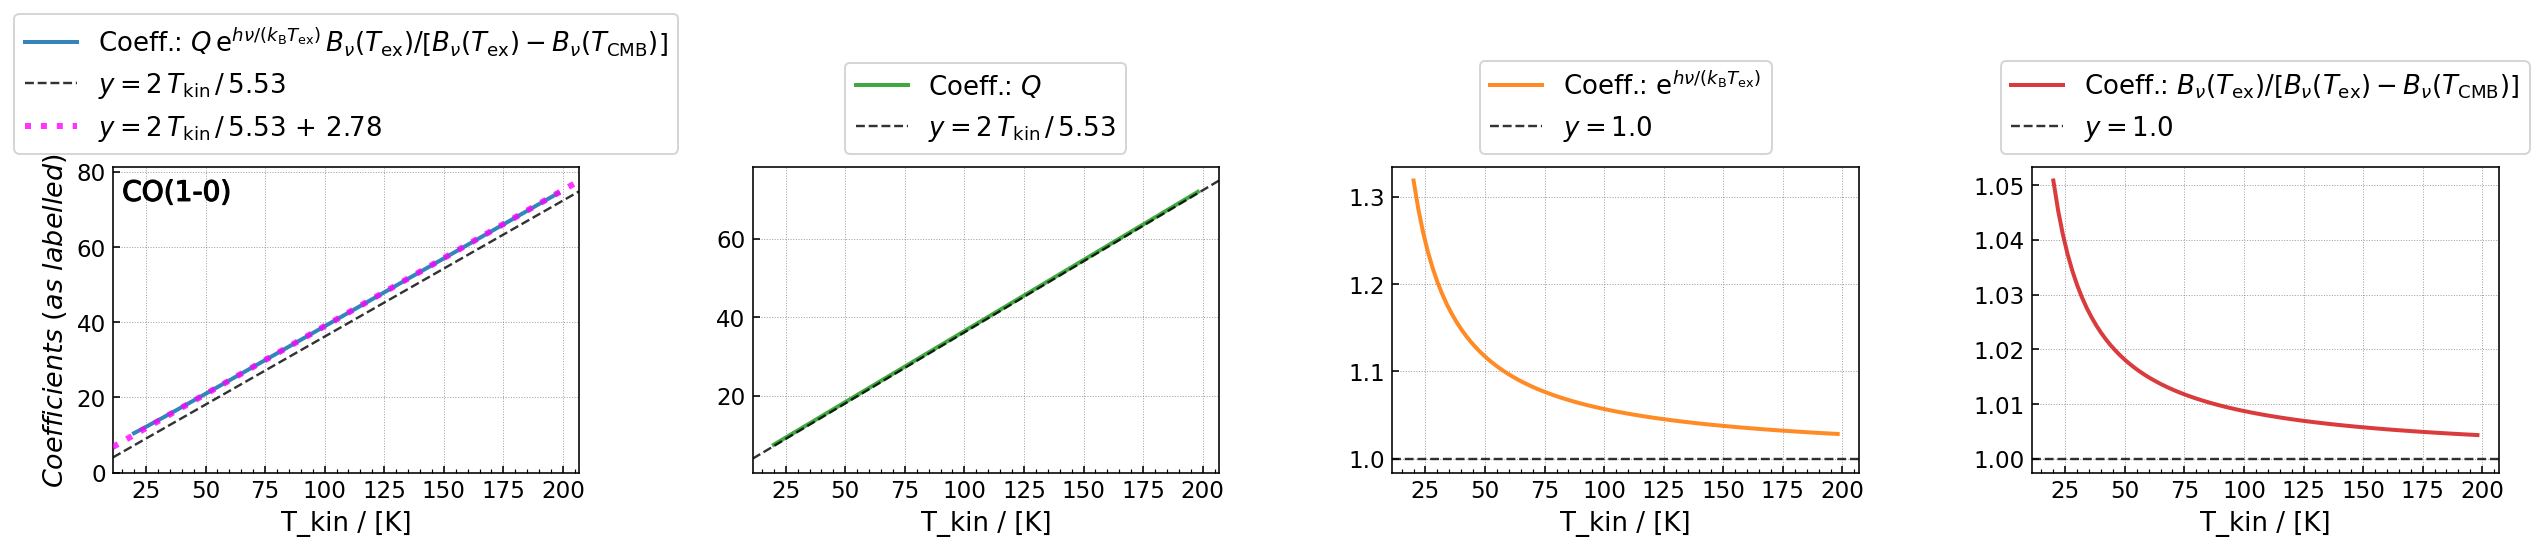

In [305]:
# CO10
z = 0. # 0. 4. 10.
nu = CO['nu'][0] * u.GHz
A_ul = CO['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
j_u = 1 # 1-0
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CO['E_u'][0] # always 1-0 upper level, do not set a unit here

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
coe3 = (coe2 * (const.m_p + const.m_e).cgs*2).to(u.M_sun * u.pc**(-2) * u.K**(-1) * u.km**(-1) * u.s)
print('coe3', coe3)

# X_CO^{-1} * 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul [M_sun pc-2 (K km s-1)-1]
X_CO = 1e-4 # [CO/H2]
coe4 = X_CO**(-1) * coe3 * 20
print('coe4', coe4)

# 
list_of_T_kin = np.arange(20., 200., 2.) * u.K
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) ) for T_kin in list_of_T_kin ])

top_left_text = 'CO(1-0)'
out_fig_name = 'Plot_LTE_alpha_CO10'
if z > 0.0:
    top_left_text = 'CO(1-0)' + r' $z = %g$'%(z)
    out_fig_name = 'Plot_LTE_alpha_CO10_z%g'%(z)
fig = make_a_plot_vs_T_kin(list_of_T_kin, Q, ehnukt, Bnuratio, E_1, top_left_text=top_left_text, out_fig_name=out_fig_name)


T_CMB 2.73 K
coe1 1032.9755604482543 1 / (cm3 K)
coe2 298979901.72163653 s / (cm3 K)
list_of_T_kin [ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182. 184. 186.
 188. 190. 192. 194. 196. 198.] K
kfactor 4.791410874042682
Output to "Plot_LTE_alpha_CO21.pdf"


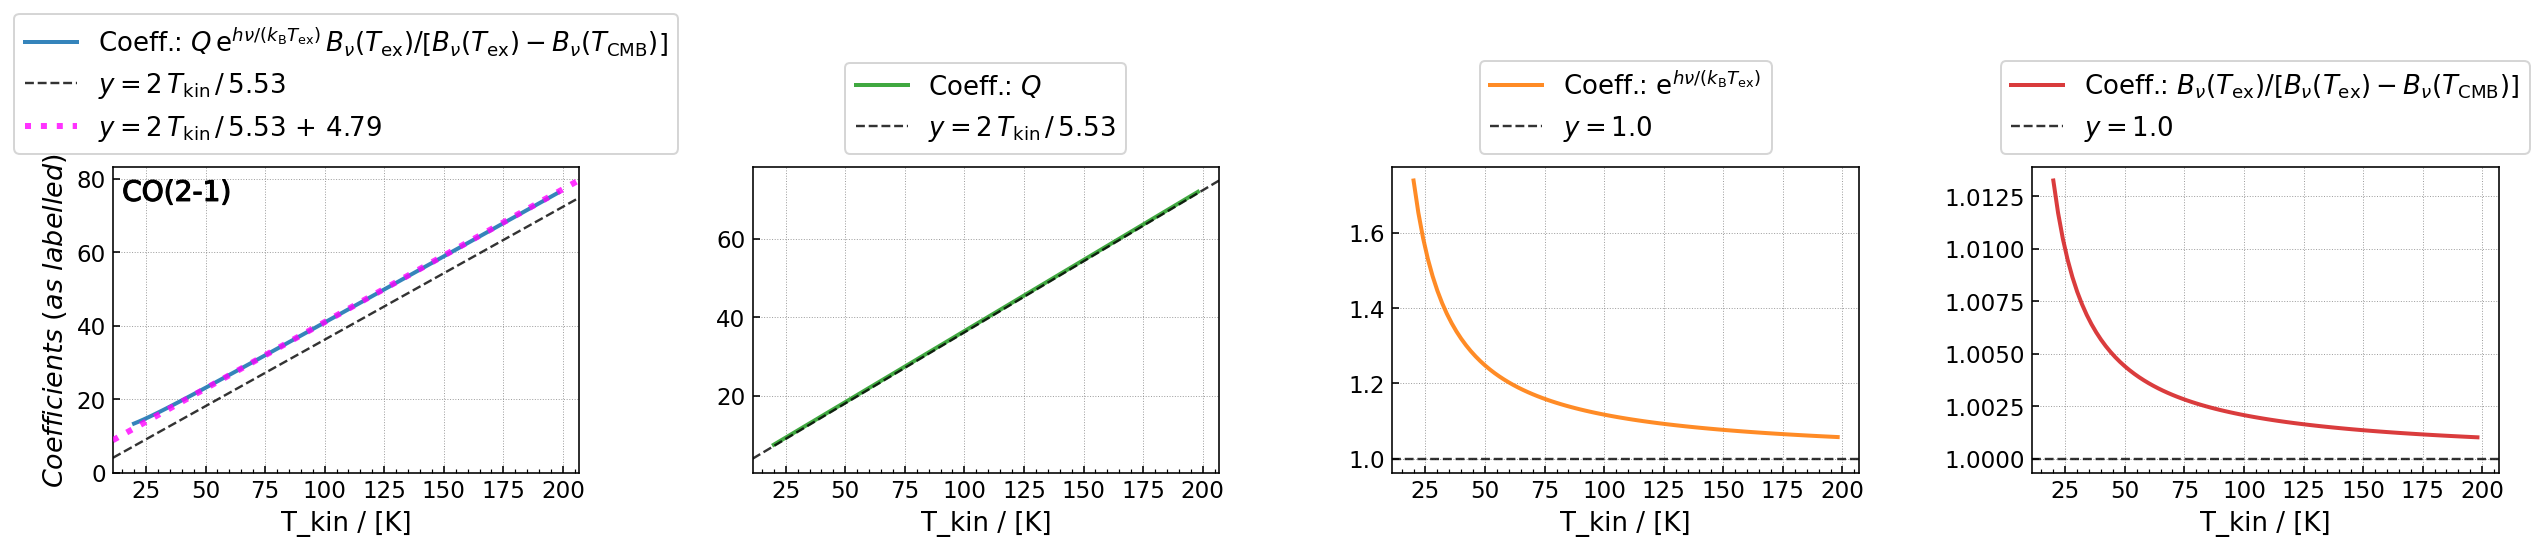

In [290]:
# CO21
z = 0. # 4.
nu = CO['nu'][1] * u.GHz # 2-1 is the second transition
A_ul = CO['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
j_u = 2 # 2-1
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CO['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 
list_of_T_kin = np.arange(20., 200., 2.) * u.K
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CO['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) ) for T_kin in list_of_T_kin ])

top_left_text = 'CO(2-1)'
out_fig_name = 'Plot_LTE_alpha_CO21'
if z > 0.0:
    top_left_text = 'CO(2-1)' + r' $z = %g$'%(z)
    out_fig_name = 'Plot_LTE_alpha_CO21_z%g'%(z)
fig = make_a_plot_vs_T_kin(list_of_T_kin, Q, ehnukt, Bnuratio, E_1, top_left_text=top_left_text, out_fig_name=out_fig_name)

T_CMB 2.73 K
coe1 4707.808412686791 1 / (cm3 K)
coe2 19914587194.10656 s / (cm3 K)
list_of_T_kin [ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182. 184. 186.
 188. 190. 192. 194. 196. 198.] K
Output to "Plot_LTE_alpha_CI10.pdf"


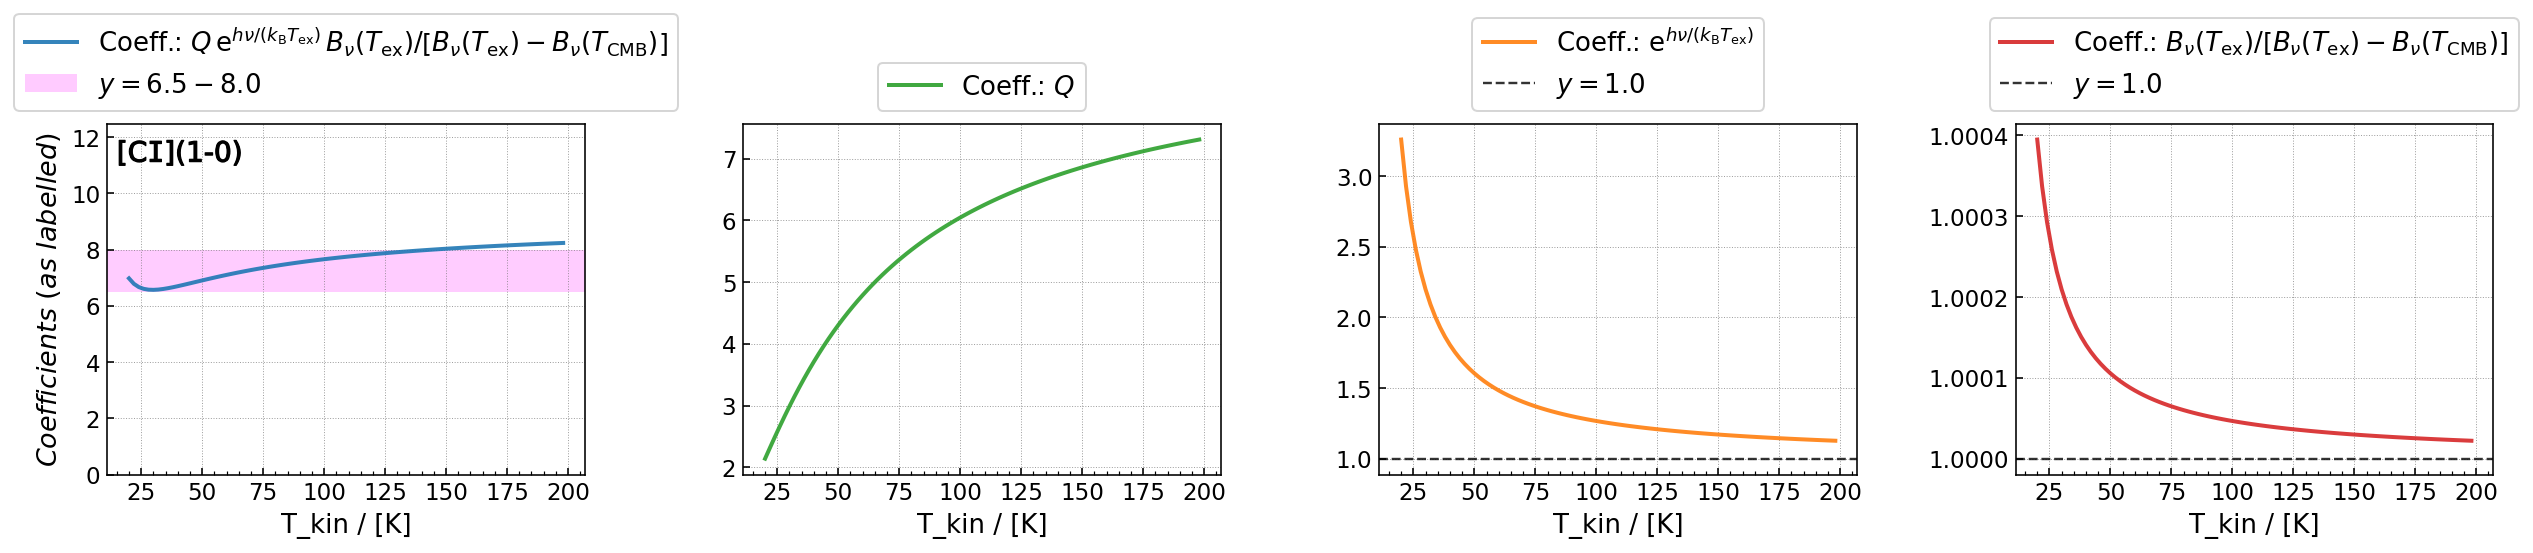

In [291]:
# CI10
z = 0. # 4.
nu = CI['nu'][0] * u.GHz # 1-0 is the first transition
A_ul = CI['Einstein_A'][0] * u.s**(-1) # 1-0 is the first transition
j_u = 1 # 1-0
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CI['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 
list_of_T_kin = np.arange(20., 200., 2.) * u.K
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) ) for T_kin in list_of_T_kin ])

top_left_text = r'[C$\tt{I}$](1-0)'
out_fig_name = 'Plot_LTE_alpha_CI10'
if z > 0.0:
    top_left_text = top_left_text + r' $z = %g$'%(z)
    out_fig_name = 'Plot_LTE_alpha_CI10_z%g'%(z)
fig = make_a_plot_vs_T_kin(list_of_T_kin, Q, ehnukt, Bnuratio, E_1, top_left_text=top_left_text, out_fig_name=out_fig_name)

T_CMB 2.73 K
coe1 12731.193778019833 1 / (cm3 K)
coe2 9608448134.354591 s / (cm3 K)
list_of_T_kin [ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182. 184. 186.
 188. 190. 192. 194. 196. 198.] K
Output to "Plot_LTE_alpha_CI21.pdf"


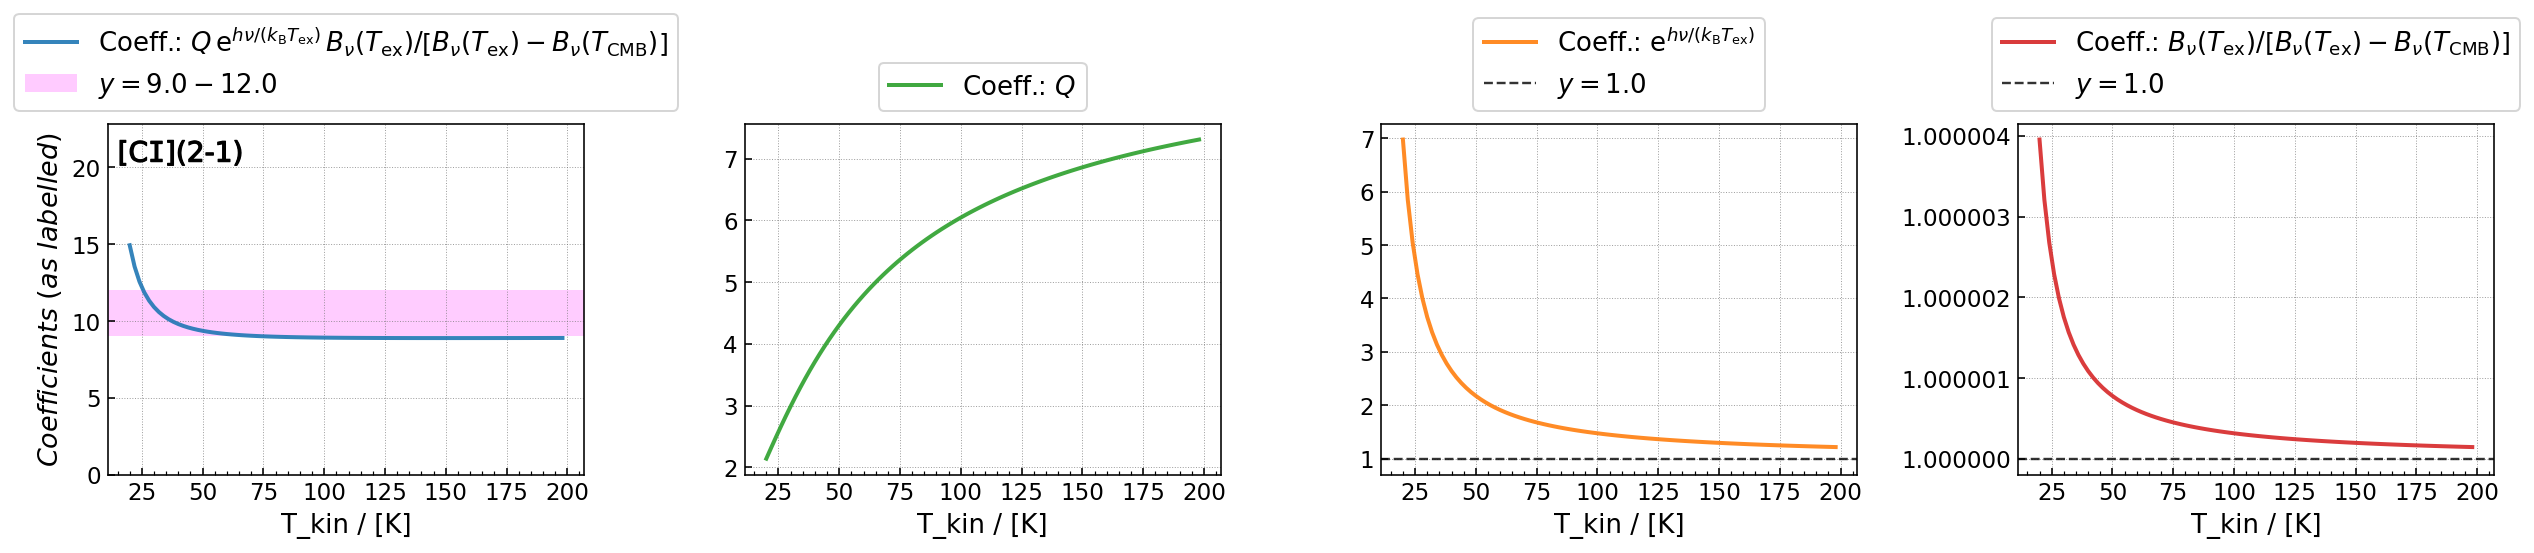

In [292]:
# CI21
z = 0. # 4.
nu = CI['nu'][1] * u.GHz # 2-1 is the second transition
A_ul = CI['Einstein_A'][1] * u.s**(-1) # 2-1 is the second transition
j_u = 2 # 2-1
g_u = 2*j_u + 1
T_CMB = 2.73 * (1.0 + z) * u.K
E_1 = CI['E_u'][0] # always 1-0 upper level 

print('T_CMB', T_CMB)

# 8 pi kB nu^2 / ( h c^3 )
coe1 = 8 * np.pi * const.k_B.cgs * nu.cgs**2 / (const.h.cgs * const.c.cgs**3)
print('coe1', coe1)

# 8 pi kB nu^2 / ( h c^3 ) / g_u / A_ul
coe2 = coe1 / g_u / A_ul
print('coe2', coe2)

# 
list_of_T_kin = np.arange(20., 200., 2.) * u.K
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)
Q = np.array([ calc_Q(CI['E_u'], T_kin.value) for T_kin in list_of_T_kin ])
ehnukt = np.array([ np.exp(const.h.cgs * nu.cgs / (const.k_B.cgs * T_kin)) for T_kin in list_of_T_kin ])
Bnuratio = np.array([ calc_Bnu(nu.to(u.GHz).value, T_kin.value) / ( calc_Bnu(nu.to(u.GHz).value, T_kin.value) - calc_Bnu(nu.to(u.GHz).value, T_CMB.value) ) for T_kin in list_of_T_kin ])

top_left_text = r'[C$\tt{I}$](2-1)'
out_fig_name = 'Plot_LTE_alpha_CI21'
if z > 0.0:
    top_left_text = top_left_text + r' $z = %g$'%(z)
    out_fig_name = 'Plot_LTE_alpha_CI21_z%g'%(z)
fig = make_a_plot_vs_T_kin(list_of_T_kin, Q, ehnukt, Bnuratio, E_1, top_left_text=top_left_text, out_fig_name=out_fig_name)

list_of_T_kin [ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182. 184. 186.
 188. 190. 192. 194. 196. 198.] K
N_CO 1e+18
N_CO 5e+18
N_CO 1e+19
list_of_tau_dict['N_CO_5e18'] [7.55584684 6.34676884 5.40592824 4.65956047 4.05759192 3.5650718
 3.15700955 2.81515562 2.52593302 2.2790727  2.06669202 1.8826592
 1.72214678 1.58131245 1.45706734 1.34690551 1.24877681 1.16099092
 1.08214412 1.01106298 0.94676041 0.8884013  0.83527527 0.78677495
 0.7423786  0.70163601 0.66415702 0.6296022  0.59767513 0.56811601
 0.54069635 0.51521458 0.49149233 0.46937126 0.44871048 0.42938423
 0.41128001 0.39429695 0.37834435 0.36334051 0.34921166 0.33589

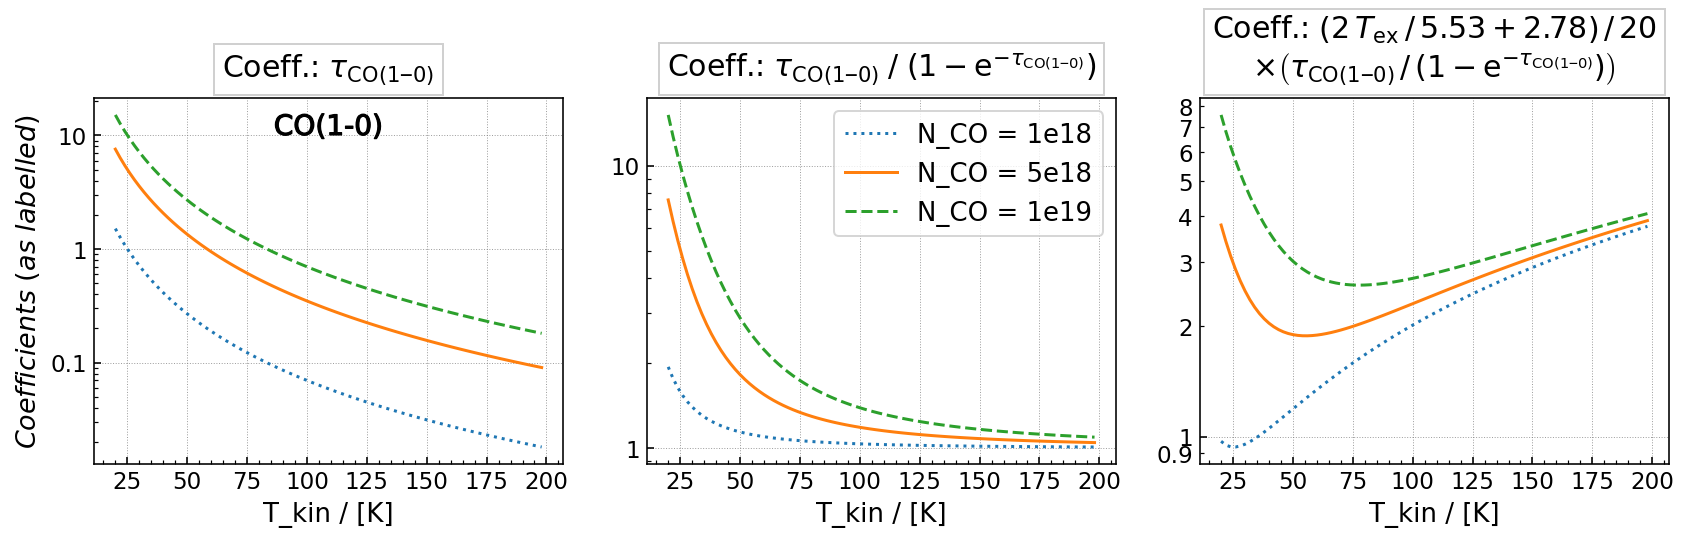

In [382]:
# tau CO10
z = 0. # 0. 4. 10.
idx_trans = 0 # 1-0 is the first transition
#nu = CO['nu'][idx_trans] * u.GHz
#A_ul = CO['Einstein_A'][idx_trans] * u.s**(-1)
j_u = 1 # 1-0 upper level is 1
#g_u = 2*j_u + 1
#T_CMB = 2.73 * (1.0 + z) * u.K
#E_1 = CO['E_u'][0] # always 1-0 upper level, do not set a unit here
N_H2 = 5e22
N_dV = 5e18 / 30.
d_V = 30.

# 
list_of_T_kin = np.arange(20., 200., 2.) * u.K
if np.count_nonzero(list_of_T_kin < T_CMB) > 0:
    list_of_T_kin = list_of_T_kin[list_of_T_kin>T_CMB]
print('list_of_T_kin', list_of_T_kin)

list_of_N_CO_str = ['1e18', '5e18', '1e19']
list_of_N_CO_linestyle = ['dotted', 'solid', 'dashed']

list_of_tau_dict = {}
for N_CO_str in list_of_N_CO_str:
    N_CO = float(N_CO_str)
    print('N_CO', N_CO)
    N_dV = N_CO / d_V
    list_of_tau = np.array([
        calc_tau(
            nu = CO['nu'][idx_trans], 
            g_u = 2*j_u+1, 
            Q = calc_Q(CO['E_u'], T_ex.value), 
            A_ul = CO['Einstein_A'][idx_trans],
            N_dV = N_dV, 
            T_ex = T_ex.value, 
        ) for T_ex in list_of_T_kin 
    ])
    list_of_tau_dict['N_CO_%s'%(N_CO_str)] = copy.copy(list_of_tau)

print("list_of_tau_dict['N_CO_5e18']", list_of_tau_dict['N_CO_5e18'])
    
top_left_text = r'$\tau_{\mathrm{CO}(1-0)}$'
out_fig_name = 'Plot_LTE_tau_CO10'
if z > 0.0:
    top_left_text = top_left_text + r' $z = %g$'%(z)
    out_fig_name = out_fig_name + '_z%g'%(z)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
for N_CO_str, linestyle in list(zip(list_of_N_CO_str, list_of_N_CO_linestyle)):
    list_of_tau = list_of_tau_dict['N_CO_%s'%(N_CO_str)]
    ax1.plot(list_of_T_kin, list_of_tau, ls=linestyle, label='N_CO = %s'%(N_CO_str))
    ax2.plot(list_of_T_kin, list_of_tau / (1.0 - np.exp(-list_of_tau)), ls=linestyle, label='N_CO = %s'%(N_CO_str))
    ax3.plot(list_of_T_kin, (2 * list_of_T_kin.value / 5.53 + 2.78) / 20. * list_of_tau / (1.0 - np.exp(-list_of_tau)), ls=linestyle, label='N_CO = %s'%(N_CO_str))

ax1.set_xlabel('T_kin / [K]', fontsize=13)
ax1.set_ylabel(r'$Coefficients \ (as \ labelled)$', fontsize=13.5)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax1.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(25.))
tt1 = ax1.text(0.5, 1.03, 
               'Coeff.: ' + 
               r'$\tau_{\mathrm{CO}(1{\tt{-}}0)}$', 
               ha='center', va='bottom', transform=ax1.transAxes, fontsize=15)
tt1.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

ax2.set_xlabel('T_kin / [K]', fontsize=13)
ax2.set_yscale('log')
#ax2.set_ylim([0.5, 100])
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax2.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(25.))
tt2 = ax2.text(0.5, 1.03, 
               'Coeff.: ' + 
               r'$\tau_{\mathrm{CO}(1{\tt{-}}0)} \; / \; (1 - \mathrm{e}^{ - \tau_{\mathrm{CO}(1{\tt{-}}0)} })$', 
               ha='center', va='bottom', transform=ax2.transAxes, fontsize=15)
tt2.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

ax3.set_xlabel('T_kin / [K]', fontsize=13)
ax3.set_yscale('log')
#ax3.set_ylim([0.5, 100])
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax3.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
ax3.grid(True, ls='dotted', lw=0.5, color='#777777', alpha=0.7)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(25.))
tt3 = ax3.text(0.5, 1.03, 
               'Coeff.: ' + 
               r'$\left( 2 \, T_{\mathrm{ex}} \, / \, 5.53 + 2.78 \right) \, / \, 20$' + 
               '\n' + 
               r'$\times \left( \tau_{\mathrm{CO}(1{\tt{-}}0)} \, / \, (1 - \mathrm{e}^{ - \tau_{\mathrm{CO}(1{\tt{-}}0)} }) \right)$', 
               ha='center', va='bottom', transform=ax3.transAxes, fontsize=15)
tt3.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='#666666'))

# show canonical alphaCO in panel 3

top_left_text = r'CO(1-0)'
out_fig_name = 'Plot_LTE_tau_CO10'
if z > 0.0:
    top_left_text = top_left_text + r' $z = %g$'%(z)
    out_fig_name = 'Plot_LTE_alpha_CI21_z%g'%(z)

tt1 = ax1.text(0.50, 0.96, top_left_text, ha='center', va='top', transform=ax1.transAxes, fontsize=14)
tt1.set_path_effects([path_effects.Stroke(linewidth=0.6, foreground='black'), path_effects.Normal()])
ax2.legend(fontsize=13)

fig.tight_layout()
fig.savefig(out_fig_name + '.pdf', dpi=300)
print('Output to "%s"'%(out_fig_name + '.pdf'))